# Regression Model: Used Car Price Prediction

**Author:** Vinicius Moreira

### Main Objective
The objective of this project is to develop a high-performance regression model to predict the selling price of used cars in the Brazilian market. To do so, we will use a large dataset of real advertisements and apply advanced feature engineering techniques.

### Technical Focus
This notebook documents the complete process, focusing on:
* **Statistical and Exploratory Data Analysis (EDA):** Deeply understand the characteristics and distributions of the dataset.
* **Feature Engineering:** Create new informative variables from the raw data.
* **Model Construction and Fine-Tuning:** Adapt a pre-trained Transformer model (`BERTimbau`) for the tabular regression task, building the training loop "by hand" with PyTorch.
* **GPU Acceleration:** Utilize a local GPU (NVIDIA CUDA) to massively accelerate model training time.

In [ ]:
!pip install tqdm
!pip install transformers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib
import json
from sklearn.metrics import mean_absolute_error
from tqdm.auto import tqdm
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch import nn
from transformers import AutoModel
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict
import time

sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12})

if torch.cuda.is_available():
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("GPU not detected, training will be done on CPU")
    device = torch.device("cpu")


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


GPU detected: NVIDIA GeForce RTX 2060 SUPER



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Loading the Data

The foundation of any Machine Learning project is data. In this section, i will establish a connection to Google Drive, where our dataset is persistently stored, and load it into a Pandas dataframe. This will allow to begin manipulation and analysis

In [ ]:
caminho_do_arquivo = os.path.join('data', 'raw', 'car_prices.csv')

try:
    df = pd.read_csv(caminho_do_arquivo)
    print(f"dataset loaded, finded {df.shape[0]} lines and {df.shape[1]} columns")
except FileNotFoundError:
    print(f"docs not finded in '{caminho_do_arquivo}'.")
except Exception as e:
    print(f"unexpected error: {e}")

dataset loaded, finded 558837 lines and 16 columns


## 2. Initial Inspection and Data Quality Diagnosis

Before any in-depth analysis, it is crucial to perform a health diagnosis of my data. In this step, i will answer three key questions:
1. What is the structure of the data?
2. What are the data types of each column?
3. How big is the missing data problem?

My hypothesis is that columns that rely on manual data entry, such as trim or interior, will have a significant percentage of null values, requiring a specific treatment strategy.

In [ ]:
print("5 firs lines")
display(df.head())

print("\ngeral information and type of data")
df.info()

print("\n% null values per column")
porcentagem_nulos = (df.isnull().sum() / len(df)) * 100
print(porcentagem_nulos[porcentagem_nulos > 0].sort_values(ascending=False))

5 firs lines


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)



geral information and type of data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ 

### 3. Data Cleaning and Missing Values ​​Handling

Based on the previous diagnosis, i will now clean and prepare my dataset. The strategy i will be:
1. Remove rows that contain null values ​​in columns that are almost complete.
2. Fill the null values ​​of the most important categorical columns with the mode (the most frequent value).
3. Fill the null values ​​of the numeric column condition with the median.
4. Convert the saledate column to datetime format.

In [ ]:
df_limpo = df.copy()

colunas_quase_completas = ['sellingprice', 'mmr', 'odometer', 'color', 'interior', 'vin', 'saledate']
linhas_antes = len(df_limpo)
df_limpo.dropna(subset=colunas_quase_completas, inplace=True)
linhas_depois = len(df_limpo)
print(f"removed {linhas_antes - linhas_depois} lines on light cleaning")

colunas_para_imputar_moda = ['make', 'model', 'trim', 'body', 'transmission']
for col in colunas_para_imputar_moda:
    moda = df_limpo[col].mode()[0]
    df_limpo[col] = df_limpo[col].fillna(moda)
    print(f"null values in '{col}' filled with: '{moda}'")

mediana_condition = df_limpo['condition'].median()
df_limpo['condition'].fillna(mediana_condition, inplace=True)
print(f"null values ​​in 'condition' filled with median: {mediana_condition}")


df_limpo['saledate'] = pd.to_datetime(df_limpo['saledate'], utc=True, errors='coerce')
df_limpo.dropna(subset=['saledate'], inplace=True)
print("column 'saledate' converted to datetime type")

valores_nulos_restantes = df_limpo.isnull().sum().sum()
if valores_nulos_restantes == 0:
    print("There are no more null values ​​in the dataset")
else:
    print(f"there are still some left {valores_nulos_restantes} null values")

print(f"\nfinal DataFrame size: {df_limpo.shape[0]} lines")

removed 874 lines on light cleaning
null values in 'make' filled with: 'Ford'
null values in 'model' filled with: 'Altima'
null values in 'trim' filled with: 'Base'
null values in 'body' filled with: 'Sedan'
null values in 'transmission' filled with: 'automatic'
null values ​​in 'condition' filled with median: 35.0


C:\Users\Bruno\AppData\Local\Temp\ipykernel_18960\2553974628.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_limpo['condition'].fillna(mediana_condition, inplace=True)
C:\Users\Bruno\AppData\Local\Temp\ipykernel_18960\2553974628.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_limpo['saledate'] = pd.to_datetime(df_limpo['saledate'], utc=True, errors='coerce')


column 'saledate' converted to datetime type
There are no more null values ​​in the dataset

final DataFrame size: 557963 lines


## 4. Feature engineering (new columns)

With the data cleaned, i can now create more informative features for our model. Machine learning models rarely learn well from raw data; i need features that capture patterns more explicitly.

i will create two very important features:
1. **Car Age:** Instead of model year, car age is a much more powerful feature for predicting depreciation and price.
2. **Sale Date Features:** We will extract the month, day of the week, and day of the year from the sale date. This can capture market seasonality (e.g. do cars sell more in December?).

In [ ]:
df_features = df_limpo.copy()

ano_atual = pd.to_datetime('now').year
df_features['age'] = ano_atual - df_features['year']
print("feature 'age' created")

df_features['sale_month'] = df_features['saledate'].dt.month
df_features['sale_dayofweek'] = df_features['saledate'].dt.dayofweek
df_features['sale_dayofyear'] = df_features['saledate'].dt.dayofyear
print("features of data ('sale_month', 'sale_dayofweek', 'sale_dayofyear') created")

df_features = df_features.drop(['year', 'saledate'], axis=1)
print("original columns 'year' e 'saledate' removed")

print("\nsample of dataframe with new features")
display(df_features[['age', 'sale_month', 'sale_dayofweek', 'sale_dayofyear', 'sellingprice']].head())

feature 'age' created
features of data ('sale_month', 'sale_dayofweek', 'sale_dayofyear') created
original columns 'year' e 'saledate' removed

sample of dataframe with new features


,age,sale_month,sale_dayofweek,sale_dayofyear,sellingprice
0,10,12,1,350,21500.0
1,10,12,1,350,21500.0
2,11,1,2,14,30000.0
3,10,1,2,28,27750.0
4,11,12,3,352,67000.0


### 4.1. Advanced Feature Engineering

To further enrich the dataset, I will create interaction and popularity features. These features can capture more complex relationships that are not obvious to the model if it just looks at the columns individually.

1. **Popularity Features:** I will calculate the frequency of each make and model to create features that represent how common or rare a vehicle is in the market.

2. **Interaction Feature (Vehicle Usage):** I will create a km_per_year feature by dividing the odometer by the age of the car. This normalizes the mileage by age, giving a much clearer measure of the "usage level" of the vehicle.

In [ ]:
df_advanced_features = df_features.copy()

make_counts = df_advanced_features['make'].value_counts(normalize=True)
df_advanced_features['make_popularity'] = df_advanced_features['make'].map(make_counts)
print("feature 'make_popularity' created")

model_counts = df_advanced_features['model'].value_counts(normalize=True)
df_advanced_features['model_popularity'] = df_advanced_features['model'].map(model_counts)
print("feature 'model_popularity' created")

df_advanced_features['km_per_year'] = df_advanced_features['odometer'] / (df_advanced_features['age'] + 1)
print("feature 'km_per_year' created")

print("\nsample of dataframe with new features")
display(df_advanced_features[['make', 'make_popularity', 'model', 'model_popularity', 'age', 'odometer', 'km_per_year', 'sellingprice']].head())

df_features = df_advanced_features
print("\nmain DataFrame updated with new features")

feature 'make_popularity' created
feature 'model_popularity' created
feature 'km_per_year' created

sample of dataframe with new features


,make,make_popularity,model,model_popularity,age,odometer,km_per_year,sellingprice
0,Kia,0.032387,Sorento,0.006108,10,16639.0,1512.636364,21500.0
1,Kia,0.032387,Sorento,0.006108,10,9393.0,853.909091,21500.0
2,BMW,0.036965,3 Series,0.014671,11,1331.0,110.916667,30000.0
3,Volvo,0.006773,S60,0.002063,10,14282.0,1298.363636,27750.0
4,BMW,0.036965,6 Series Gran Coupe,0.000186,11,2641.0,220.083333,67000.0



main DataFrame updated with new features


## 5. Preparing the Transformer: Converting Rows to Strings

Transformer models, such as BERT, which I will use for fine-tuning, are experts at understanding the meaning and relationships in sequences of text. In order for it to "understand" the data about a car, we need a strategy to convert each row of our dataframe into a single "sentence" that describes the vehicle in a structured way.

**My approach will be:**
1. Select the most relevant features that we want the model to consider.
2. For each car (row), create a single string that combines the feature name and its value, separating them with a special character.

For example, a car will become the sentence:
`make [Ford] | model [Ka] | age [7] | odometer [50000] | [manual] transmission

This textual representation allows the Transformer's "attention" mechanism to learn the complex interactions between the different features of the car, much like it learns the relationships between words in a typical sentence.

In [ ]:

features_para_texto = [
    'make', 'model', 'trim', 'body', 'transmission', 'color',
    'interior', 'age', 'odometer', 'sale_month', 'sale_dayofweek'
]

def criar_representacao_textual(row):
    partes = [f"{coluna} [{str(row[coluna])}]" for coluna in features_para_texto]
    return " | ".join(partes)

df_features['text'] = df_features.apply(criar_representacao_textual, axis=1)
print("column text created")

df_final = df_features[['text', 'sellingprice']].copy()

print("\nsample of strings created")
for i in range(5):
    print(f"Carro {i}:")
    print(df_final['text'].iloc[i])
    print("-" * 20)

column text created

sample of strings created
Carro 0:
make [Kia] | model [Sorento] | trim [LX] | body [SUV] | transmission [automatic] | color [white] | interior [black] | age [10] | odometer [16639.0] | sale_month [12] | sale_dayofweek [1]
--------------------
Carro 1:
make [Kia] | model [Sorento] | trim [LX] | body [SUV] | transmission [automatic] | color [white] | interior [beige] | age [10] | odometer [9393.0] | sale_month [12] | sale_dayofweek [1]
--------------------
Carro 2:
make [BMW] | model [3 Series] | trim [328i SULEV] | body [Sedan] | transmission [automatic] | color [gray] | interior [black] | age [11] | odometer [1331.0] | sale_month [1] | sale_dayofweek [2]
--------------------
Carro 3:
make [Volvo] | model [S60] | trim [T5] | body [Sedan] | transmission [automatic] | color [white] | interior [black] | age [10] | odometer [14282.0] | sale_month [1] | sale_dayofweek [2]
--------------------
Carro 4:
make [BMW] | model [6 Series Gran Coupe] | trim [650i] | body [Sedan] 

## 6. Splitting the Data: Creating the Training and Test Sets

One of the most important rules in Machine Learning is to never evaluate the model with the same data it used to learn.

To ensure an honest assessment of the models performance, I will split the dataset into two distinct groups using scikit-learn's train_test_split function:

1. **Training Set (80% of the data):** This will be used during the training phase so that the model learns the patterns between a car's features and its price.

2. **Test Set (remaining 20%):** This will be "saved" and untouched. We will only use this set at the end of the project to see how well the model generalizes to data it has never seen before.

In addition, I will apply the logarithmic transformation (np.log1p) to the target variable (sellingprice) before the split. As we saw in the exploratory analysis, this helps to normalize the price distribution, which stabilizes and improves the training of the neural network.

In [ ]:
X = df_final['text']
y = df_final['sellingprice']

y_log = np.log1p(y)
print("target var 'sellingprice' transformed with log(1+x).")

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print("\ndivision conclude")
print(f"training set size (X_train): {X_train.shape[0]} samples")
print(f"test set size (X_test):   {X_test.shape[0]} samples")
print(f"training target size (y_train_log): {y_train_log.shape[0]} samples")
print(f"test target size (y_test_log):   {y_test_log.shape[0]} samples")

target var 'sellingprice' transformed with log(1+x).

division conclude
training set size (X_train): 446370 samples
test set size (X_test):   111593 samples
training target size (y_train_log): 446370 samples
test target size (y_test_log):   111593 samples


## 7. Tokenization: Translating Text into Model Language

Neural networks, and especially Transformer models, don’t understand words like ‘Ford’ or ‘auto’. They understand tokens. Tokenization is the process of “translating” the descriptive phrases I created for each car into a sequence of numbers (tokens) that the BERT model (BERTimbau) has been pre-trained to recognize.

For each “phrase”, the tokenizer will generate two main outputs:
* **input_ids:** The list of numeric IDs that represent each word or subword. Each number corresponds to an entry in the model’s vocabulary.
* **attention_mask:** A list of 1s and 0s that tells the model which tokens are actual words (1) and which are “padding” (0) added just to make sure all the sequences in a batch are the same length.

I will use Hugging Face's transformers library to load the exact tokenizer corresponding to the BERTimbau model, ensuring full compatibility.

In [ ]:
MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

print(f"loading tokenizer of model: '{MODEL_NAME}'...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("tokenizer loaded")

MAX_LEN = 128

print("\ntokenizing data's training")

train_encodings = tokenizer(
    list(X_train),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors='pt'
)

print("tokenizing test data's")
test_encodings = tokenizer(
    list(X_test),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors='pt'
)

print("\ntokenizing loaded")
print(f"shape of the input_ids of training: {train_encodings['input_ids'].shape}")

loading tokenizer of model: 'neuralmind/bert-base-portuguese-cased'...
tokenizer loaded

tokenizing data's training
tokenizing test data's

tokenizing loaded
shape of the input_ids of training: torch.Size([446370, 104])


## 8. Creating the PyTorch Dataset

Now that the data is in the correct numeric format (tokens), I need to organize it into a structure that PyTorch understands natively. To do this, I'll create a custom Dataset class.

To create a custom Dataset in PyTorch, the class needs three special methods:
* `__init__()`: The constructor, where we receive and store our data.
* `__len__()`: A simple method that returns the total number of samples in the dataset.
* `__getitem__()`: The most important method. This is the one that is called when we request dataset[52]. It is responsible for fetching and returning a single sample of data.

In [ ]:
class CarPriceDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CarPriceDataset(train_encodings, y_train_log.values)
test_dataset = CarPriceDataset(test_encodings, y_test_log.values)

print("training and test dataset created")
print(f"number of samples in train_dataset: {len(train_dataset)}")
print(f"number of samples in test_dataset: {len(test_dataset)}")

print("\none example item of dataset :")
print(train_dataset[0])

training and test dataset created
number of samples in train_dataset: 446370
number of samples in test_dataset: 111593

one example item of dataset :
{'input_ids': tensor([  101,   223,  1550,   164,  3802, 22292,  3157,   735,   166,   196,
        12066,   164,  2025,   840,   166,   196,  1480, 22287,   164,   276,
        22321,   166,   196,  1151,  4071,   164,   530, 12717,   166,   196,
         2153,  6510,   164,  9577,   393,   166,   196,  9164,   164, 12486,
         3391, 22331,   166,   196,  2699,   164,   416, 22326,   166,   196,
         9174,   164,  1433,   166,   196,   146, 10164,   735,   140,   164,
         2336, 21906, 22307,   119,  2297,   166,   196,  1390, 22279,   168,
         2713, 22296,   164,   511,   166,   196,  1390, 22279,   168,   180,
         3961, 22294,  4132,  6505,   164,   245,   166,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'token_type_ids': 

## 9. Creating the DataLoader for Batch Training

Its function is to take the data from the Dataset and group it into batches. Instead of training the model with one car at a time, which would be very inefficient, I will train it with a batch of, for example, 16 or 32 cars simultaneously. This maximizes the use of the GPU, since it is specialized in doing many mathematical operations in parallel.

In addition, the training DataLoader has a crucial function: to shuffle the data at each new "epoch" (a complete pass through the training dataset). This ensures that the model does not learn any accidental order in the data, which improves its generalization ability.

In [ ]:
BATCH_SIZE = 16
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("dataloarder of training and tests created")
print(f"the training DataLoader will have approximately {len(train_loader)} lots per epoch")
print(f"the test DataLoader will be approximately {len(test_loader)} lots")

dataloarder of training and tests created
the training DataLoader will have approximately 27899 lots per epoch
the test DataLoader will be approximately 6975 lots


## 10. Building the Model Architecture with PyTorch and Transformers

This is the core AI engineering step of the project: defining the "brain" of the system, which will learn to predict prices. To do this, I will use a powerful and efficient technique called Transfer Learning.

We will not build a neural network from scratch. Instead, we will take a giant pre-trained model, BERTimbau, and fine-tune it for the specific regression task.

Our architecture will have two main parts:

1. **The Backbone:** The pre-trained BERTimbau. Its job will be to read the "sentence" that describes the car (e.g. `make [Ford] | model [Ka]...`) and generate a rich vector representation that captures all the meaning and relationships between the features.

2. **The Regression "Head":** This is the custom part. We will add on top of BERT a small neural network with a few linear layers. Its job is to take the rich BERT representation and map it to a single number: the predicted price of the car.

To combat overfitting, I’ll add Dropout layers to the regression “head.” During training, they randomly turn off some neurons, forcing the network to learn more robustly and generalize better to new data.

In [ ]:
class RegressionTransformer(nn.Module):
    def __init__(self, model_name=MODEL_NAME):
        super(RegressionTransformer, self).__init__()

        print(f"loading model: {model_name}...")
        self.bert = AutoModel.from_pretrained(model_name)

        self.regressor = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(self.bert.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, 1)
        )
        print("model defined")

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        pooled_output = outputs.pooler_output
        price_prediction = self.regressor(pooled_output)
        return price_prediction

model = RegressionTransformer()

model.to(device)

print(f"\nmodel moved to device: {device}")

loading model: neuralmind/bert-base-portuguese-cased...
model defined

model moved to device: cuda


## 11. Defining the Loss Function and the Optimizer

Now that we have the model architecture, we need two last tools for training:

**1. The Loss Function The Error "Ruler"**
Think of the Loss Function as a ruler. For each price prediction the model makes, we use this ruler to measure the "distance" (the error) between the prediction and the actual price of the car. The goal of training is to make the value of this "ruler" as small as possible.

For the regression problem, I will use L1Loss, also known as Mean Absolute Error (MAE). It simply calculates the average absolute difference between the actual and predicted value (`|actual - predicted|`). It is robust and easy to interpret: an MAE of 0.1, for example, will mean that the model is missing, on average, R$ 0.1 in the log value of the price.

**2. The Optimizer**
It looks at the error measured by the ruler and, using the gradient calculated by backpropagation, adjusts each of the millions of weights in the neural network in the right direction to reduce that error.

I will use AdamW, one of the most popular and effective optimizers for training Transformers. It is an evolution of Adam that incorporates a technique called Weight Decay, one of the weapons against overfitting that helps keep the model weights small and prevent the model from becoming too complex.

In addition, I will use a Learning Rate Scheduler, which adjusts the intensity of learning over time, starting faster and making finer adjustments at the end.

In [ ]:
EPOCHS = 12
LEARNING_RATE = 2e-5

loss_function = nn.L1Loss()
print("MAE defined")


optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE
)
print(f"optimizer AdamW defined with learning rate: {LEARNING_RATE}")

total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
print("Learning Rate Scheduler configured")

MAE defined
optimizer AdamW defined with learning rate: 2e-05
Learning Rate Scheduler configured


## 12. The Training and Evaluation Functions

With all of our components defined (model, dataloaders, optimizer, etc.), let's now create the logic that ties them together. To keep the code organized, I'll create two separate functions:

1. **train_epoch() (The Training Function):**
This function will be responsible for running a full epoch of training. An "epoch" means going through our entire train_loader once. For each batch of data, this function will:
* Move the data to the GPU.
* Make a prediction with the model (forward pass).
* Calculate the error (loss) using our L1Loss.
* Calculate the gradients with backpropagation to know how to correct each model weight.
* Update the model weights using the optimizer.
* Adjust the learning rate with the scheduler.
* At the end, it will return the average error for that epoch.

2. **evaluate() (The Evaluation Function):**
This function is simpler. It will go through the test_loader and make predictions, but without updating the weights (no backpropagation or optimizer). Its only goal is to calculate the average error on the test set. It is with this function that I will monitor whether the model is actually learning to generalize and detect overfitting (when the training error drops, but the test error starts to rise).

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()

    total_loss = 0

    for batch in tqdm(data_loader, desc="Treinando..."):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = loss_fn(outputs.squeeze(), labels)

        total_loss += loss.item()

        loss.backward()

        optimizer.step()

        scheduler.step()

        optimizer.zero_grad()

    return total_loss / len(data_loader)


def evaluate(model, data_loader, loss_fn, device):

    model.eval()

    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Avaliando..."):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            loss = loss_fn(outputs.squeeze(), labels)
            total_loss += loss.item()

    return total_loss / len(data_loader)

print("funcs train_epoch and evaluate defined's")

funcs train_epoch and evaluate defined's


## 13. The Training Loop

This is the final cell of the modeling process. Here, I orchestrate everything I have built.

The following loop will loop through the data for the number of EPOCHS I have defined. At each epoch, it will do the following:

1. Call the train_epoch function to train the model on all the training data and adjust its weights.

2. Call the evaluate function to evaluate the performance of the trained model on the test set, which it has never seen before.

3. Print the training and validation loss so we can track the learning.

4. Check if the validation error for the current epoch is the lowest we have ever seen. If so, it saves the model at that point. This ensures that at the end, I will have saved the best possible "brain".

At the end, I will plot a graph to visualize the learning curve of the model.

In [ ]:
history = defaultdict(list)
best_loss = float('inf')

print("start fine-tuning")

for epoch in range(EPOCHS):

    epoch_start_time = time.time()

    print(f"\nepoch {epoch + 1}/{EPOCHS} ---")

    train_loss = train_epoch(
        model,
        train_loader,
        loss_function,
        optimizer,
        device,
        scheduler
    )

    val_loss = evaluate(
        model,
        test_loader,
        loss_function,
        device
    )

    epoch_time = time.time() - epoch_start_time
    print(f"end of epoch {epoch + 1} | time: {epoch_time:.2f}s")
    print(f"training loss: {train_loss:.4f} | validation loss: {val_loss:.4f}")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    if val_loss < best_loss:
        print("saving model")
        caminho_para_salvar = os.path.join('data', 'raw', 'best_model_state.pth')
        torch.save(model.state_dict(), caminho_para_salvar)
        best_loss = val_loss

print("\nfine-tuning conclude")
print(f"best validation loss achieved: {best_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Loss de Treino')
plt.plot(history['val_loss'], label='Loss de Validação')
plt.title('loss history by season')
plt.ylabel('Loss (MAE Log-transformed)')
plt.xlabel('epoch')
plt.legend()
plt.show()

best validation loss achieved: 0.1692
-----------------------------------------------


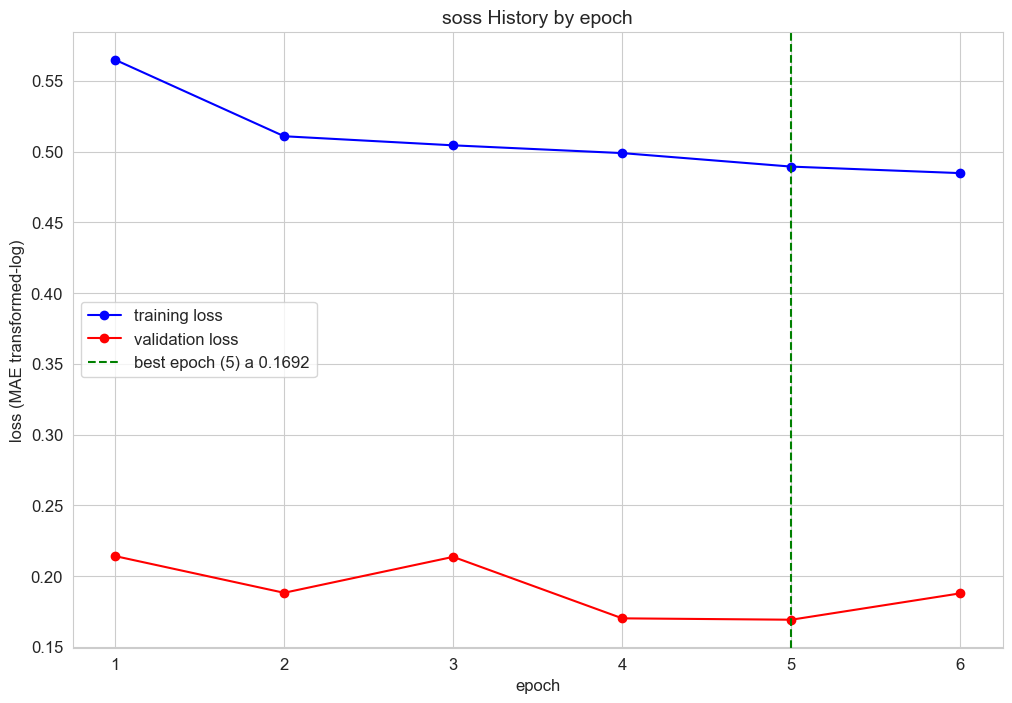

In [ ]:
# This code uses the 'history' and 'best_loss' variables that were saved during fine-tuning.

print(f"best validation loss achieved: {best_loss:.4f}")
print(f"-----------------------------------------------")

epochs_completed = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs_completed, history['train_loss'], 'b-o', label='training loss')
plt.plot(epochs_completed, history['val_loss'], 'r-o', label='validation loss')

best_epoch = np.argmin(history['val_loss']) + 1
plt.axvline(x=best_epoch, color='g', linestyle='--', label=f'best epoch ({best_epoch}) a {best_loss:.4f}')

plt.title('soss History by epoch')
plt.ylabel('loss (MAE transformed-log)')
plt.xlabel('epoch')
plt.xticks(list(epochs_completed))
plt.legend()
plt.grid(True)
plt.show()

## 14. Model Evaluation and Inference on Samples

With the model trained, we come to the final step: evaluating its performance qualitatively and quantitatively.

In this section, I will do the following:
1. **Load the Best Model:** I will load the weights from the best_model_state.pth file that I saved during training. This ensures that I am using the version of the model with the lowest validation error.
2. **Make Predictions:** I will take some samples from the test set (data that the model has never seen) and run them through the model to get its price constraints.
3. **Interpret the Results:** The output of the model is a log-transformed price. I need to reverse this transformation (np.expm1) to see the predicted price in Reais and compare it to the actual price. 4. **Calculate the Mean Absolute Error (MAE):** You calculate the average error of the variations across the entire test set to have a final, concrete performance metric: "On average, the model misses the price of cars by R$X."

In [ ]:
save_path = os.path.join('data', 'raw', 'best_model_state.pth')
inference_model = RegressionTransformer(MODEL_NAME)
inference_model.load_state_dict(torch.load(save_path))
inference_model.to(device)
inference_model.eval()
print("model loaded")

print("\ntesting model in random samples")

amostras_teste = X_test.sample(5, random_state=42)
indices = amostras_teste.index

for idx in indices:
    texto = X_test.loc[idx]
    preco_real_log = y_test_log.loc[idx]

    encoded_text = tokenizer.encode_plus(
        texto,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    with torch.no_grad():
        preco_predito_log = inference_model(input_ids, attention_mask)

    preco_real = np.expm1(preco_real_log)
    preco_predito = np.expm1(preco_predito_log.cpu().numpy()[0][0])

    erro = abs(preco_real - preco_predito)

    print(f"\nCarro: {texto[:80]}...")
    print(f"  -> Preço Real: R$ {preco_real:,.2f}")
    print(f"  -> Preço Previsto: R$ {preco_predito:,.2f}")
    print(f"  -> Erro: R$ {erro:,.2f}")

print("\ncalculing MAE")
y_pred_log_list = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="making batch predictions"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = inference_model(input_ids, attention_mask)
        y_pred_log_list.extend(outputs.cpu().numpy().flatten())

y_test_real = np.expm1(y_test_log.values)
y_pred_real = np.expm1(y_pred_log_list)

mae = mean_absolute_error(y_test_real, y_pred_real)

print(f"\nMean Absolute Error of the model on the test set is: R$ {mae:,.2f}")

loading model: neuralmind/bert-base-portuguese-cased...
model defined
model loaded

testing model in random samples

Carro: make [Nissan] | model [Sentra] | trim [2] | body [Sedan] | transmission [automat...
  -> Preço Real: R$ 4,200.00
  -> Preço Previsto: R$ 3,474.03
  -> Erro: R$ 725.97

Carro: make [Chevrolet] | model [Tahoe] | trim [LS] | body [suv] | transmission [automa...
  -> Preço Real: R$ 4,300.00
  -> Preço Previsto: R$ 5,485.43
  -> Erro: R$ 1,185.43

Carro: make [Honda] | model [CR-V] | trim [EX-L] | body [SUV] | transmission [automatic...
  -> Preço Real: R$ 18,600.00
  -> Preço Previsto: R$ 17,660.87
  -> Erro: R$ 939.13

Carro: make [Chevrolet] | model [Impala] | trim [LT] | body [Sedan] | transmission [aut...
  -> Preço Real: R$ 10,100.00
  -> Preço Previsto: R$ 9,728.56
  -> Erro: R$ 371.44

Carro: make [Toyota] | model [RAV4] | trim [Base] | body [SUV] | transmission [automati...
  -> Preço Real: R$ 15,500.00
  -> Preço Previsto: R$ 14,021.65
  -> Erro: R$ 1,478.35


making batch predictions:   0%|          | 0/6975 [00:00<?, ?it/s]


Mean Absolute Error of the model on the test set is: R$ 1,721.57


## 15. Saving the Final Artifacts for Production

In addition to the model weights, I need to save the preprocessing pipeline (ColumnTransformer) and the list of features that the model expects. This ensures that the future API can replicate exactly the same steps I took in training. I will use the joblib library to save the scikit-learn object.

In [ ]:
categorical_features = ['make', 'model', 'trim', 'body', 'transmission', 'color', 'interior']
numeric_features = ['age', 'odometer', 'sale_month', 'sale_dayofweek', 'sale_dayofyear', 'make_popularity', 'model_popularity', 'km_per_year']
text_feature = 'text'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

features_para_texto = numeric_features + categorical_features

def criar_representacao_textual(row):
    partes = [f"{coluna}[{str(row[coluna])}]" for coluna in features_para_texto]
    return " | ".join(partes)

X_text = df_features.apply(criar_representacao_textual, axis=1)
y_log = np.log1p(df_features['sellingprice'])

save_path_model = os.path.join('data', 'raw', 'best_model_state.pth')
torch.save(model.state_dict(), save_path_model)

save_path_preprocessor = os.path.join('data', 'raw', 'preprocessor.pkl')
joblib.dump(preprocessor, save_path_preprocessor)

save_path_features = os.path.join('data', 'raw', 'model_features.json')
features_dict = {'numeric': numeric_features, 'categorical': categorical_features}
with open(save_path_features, 'w') as f:
    json.dump(features_dict, f)

print(f"model saved in: {save_path_model}")
print(f"pre-processor saved in: {save_path_preprocessor}")
print(f"model features saved in: {save_path_features}")

model saved in: data\raw\best_model_state.pth
pre-processor saved in: data\raw\preprocessor.pkl
model features saved in: data\raw\model_features.json
